In [1]:
%matplotlib inline
import numpy as np                                                                                                 
import matplotlib.pyplot as plt                                                                                    
import pandas as pd

import bc_utils as butils

from scipy.spatial import distance 
from mpl_toolkits import mplot3d

from sklearn.model_selection import train_test_split                                                               
from sklearn.preprocessing import StandardScaler                                                                   
from sklearn.neighbors import KNeighborsClassifier 

# 1. Load data

In [2]:
# Read dataset to pandas dataframe
# current datasets ready for testing:
#   blobs.csv
#   blobs_3d.csv
#   iris.csv
#   mfeat-mor.csv
#   mfeat-zer.csv
#   mfeat-pix.csv
#   mfeat-fac.csv
#   mfeat-fou.csv
#   mfeat-kar.csv
#   noisy_circles.csv
#   noisy_circles_3d.csv
#   overlap.csv
#   pendigit.csv

df = pd.read_csv("data/noisy_circles_3d.csv", index_col=0)

# 2. Plot data

Visualize data if they have 2 or 3 features.

In [3]:
grouped = df.groupby('cluster')
for group in grouped:
    print(group)

(0,              x         y    z  cluster
0    -0.677999 -0.698757  0.0        0
1     0.931437  0.191391  0.0        0
3     0.872837  0.375023  0.0        0
6     0.935534 -0.069950  0.0        0
7     0.159219  0.971415  0.0        0
8    -0.611547  0.751418  0.0        0
13   -0.104486  0.942077  0.0        0
14    0.967687 -0.174183  0.0        0
15    0.754242 -0.621617  0.0        0
18   -1.027807  0.155325  0.0        0
20    0.071758  0.989000  0.0        0
21    0.655803 -0.812775  0.0        0
22    0.758490  0.629618  0.0        0
23   -0.866656 -0.497841  0.0        0
27   -0.184218 -0.921755  0.0        0
31   -0.850261  0.502583  0.0        0
36   -0.603595 -0.675230  0.0        0
37    0.120921 -0.969693  0.0        0
38   -0.699461 -0.700145  0.0        0
39   -0.829813  0.384497  0.0        0
43    0.738477 -0.657938  0.0        0
44   -0.615457  0.768498  0.0        0
45   -0.378752 -0.893043  0.0        0
47    0.940516 -0.345081  0.0        0
52    0.053183 -0.948

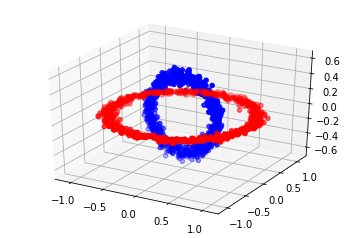

In [4]:
colors = {0:'red', 1:'blue', 2:'green'}

if (df.columns.size == 3):
    fix, ax = plt.subplots()
    grouped = df.groupby('cluster')
    
    i = 0
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y',
                   label=key, color=colors[i])
        i = i + 1
    plt.show()
elif (df.columns.size == 4):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    grouped = df.groupby('cluster')

    i = 0
    for key, group in grouped:
        ax.scatter(group['x'], group['y'], group['z'], color=colors[i])
        i = i + 1
    plt.show()
else:
    print("There is no good visualisation for this dataset - " + str(df.columns.size) + " features.")
    

In [5]:
#creating test datasets
names = set(df['cluster'])

dataframes = {}
for name in names:
    tmp_df = df[df['cluster'] == name]
    dataframes[name] = butils.TestDf(tmp_df)
    
#all data for testing
full_test_df = pd.DataFrame()

for name in names:
    full_test_df = full_test_df.append(dataframes[name].test_df)

In [6]:
def benchmark_result_plots(matrices, titles, headers, rotation_num):
    """
    parameters:
    matrices - list of 2d np.array
    titles - list of graph titles
    names - list of labels
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
    ax_list = [ax1, ax2, ax3, ax4]

    for index in range(0, len(matrices)):
        tick_labels = list(headers[index])
        ax = ax_list[index]
        ax.imshow(matrices[index], cmap='binary')

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(tick_labels)))
        ax.set_yticks(np.arange(len(tick_labels)))

        # ... and label them with the respective list entries
        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels(tick_labels)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="right")

        # Loop over data dimensions and create text annotations.
        for i in range(len(tick_labels)):
            for j in range(len(tick_labels)):
                if(matrices[index][i, j] == 0):
                    continue
                if i == j:
                    text = ax.text(j, i, matrices[index][i, j], ha="center", va="center", color="g",
                                   weight="bold", fontsize=16)
                    continue
                else:
                    text = ax.text(j, i, matrices[index][i, j], ha="center", va="center", color = "r",
                                   weight="bold", fontsize=16)
            
        ax.set_title(titles[index], fontsize=16)
    plt.savefig('noisy_circles_3d_' + str(rotation_num) + '.png')
        

Rates for each method:
greedy_select: 0.0
one_shot_medoids: 0.0
random_select: 0.0238907849829
full_medoids: 0.0
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!

Rates for each method:
greedy_select: 0.0
one_shot_medoids: 0.0
random_select: 0.0526315789474
full_medoids: 0.00671140939597
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!

Rates for each method:
greedy_select: 0.0169491525424
one_shot_medoids: 0.0
random_select: 0.048951048951
full_medoids: 0.00671140939597
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!

Rates for each method:
greedy_select: 0.0
one_shot_medoids: 0.0
random_select: 0.0526315789474
full_medoids: 0.00671140939597
Method that got the best result is full_medoids
Creating plots.


Dataset Rotated!

Rates for each method:
greedy_select: 0.00334448160535
one_shot_medoids: 0.0204081632653
random_select: 0.0830324909747
full_medoids: 0.0169491525424
Method that 

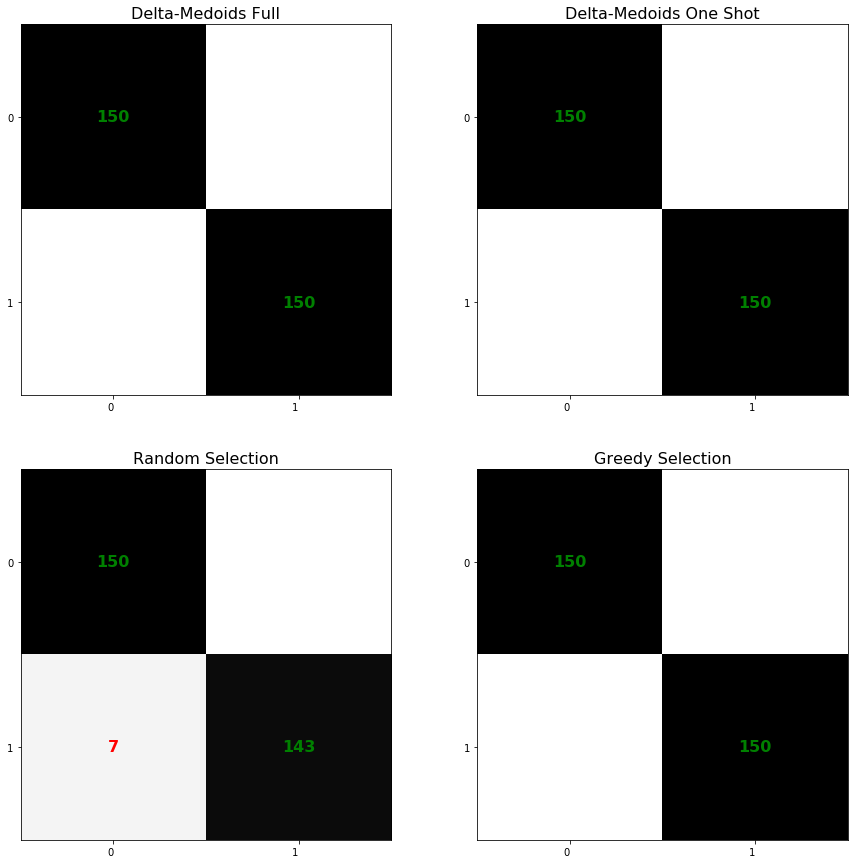

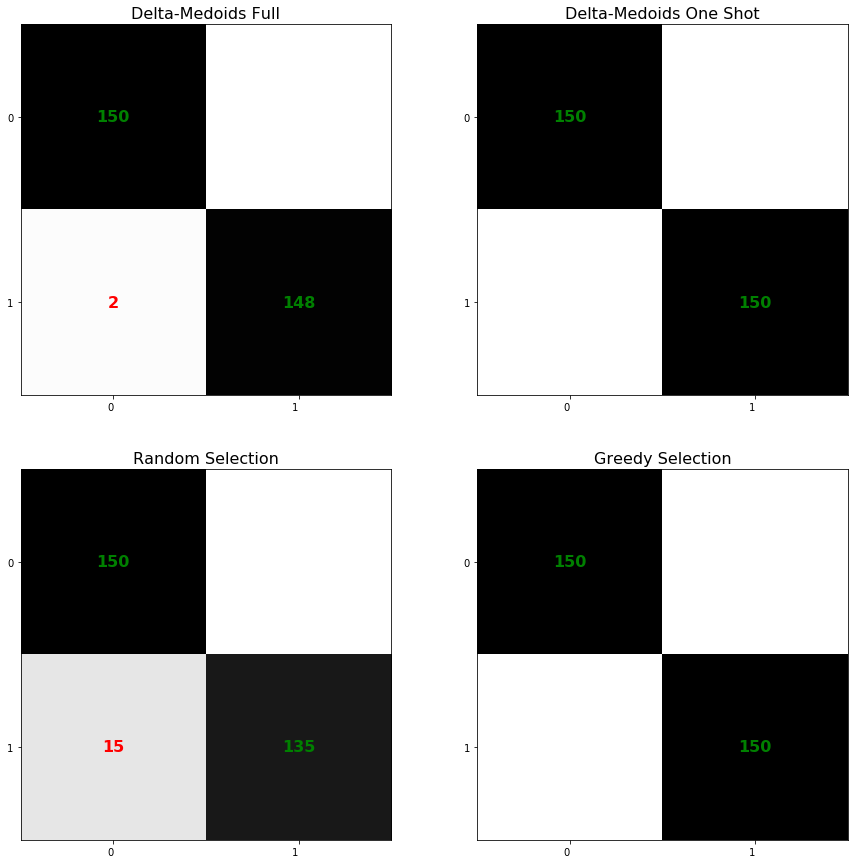

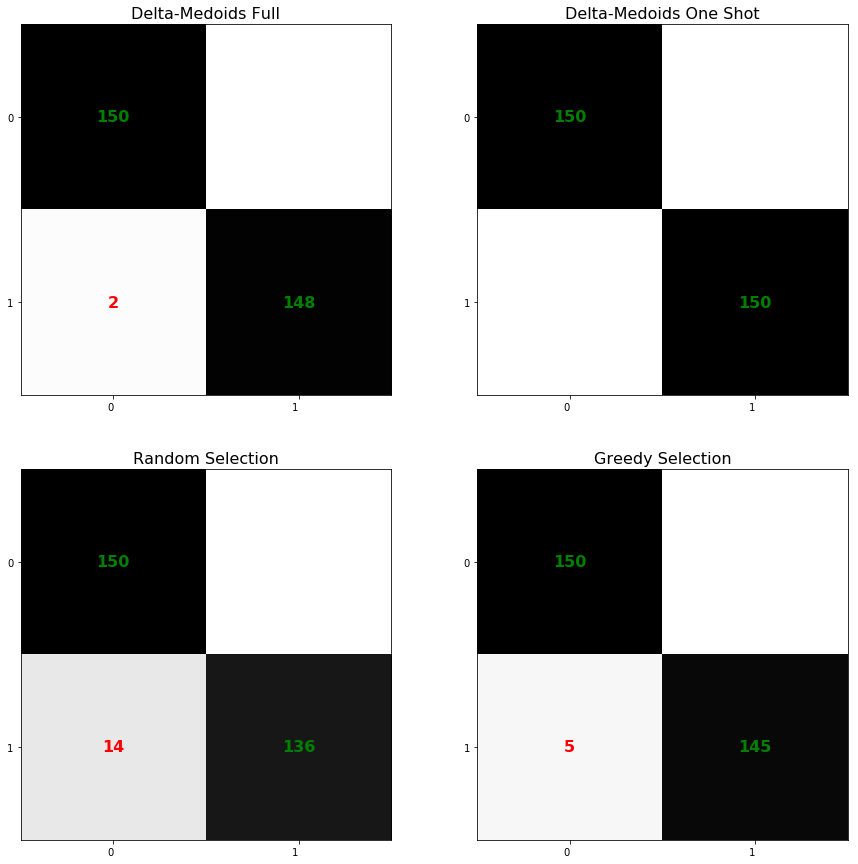

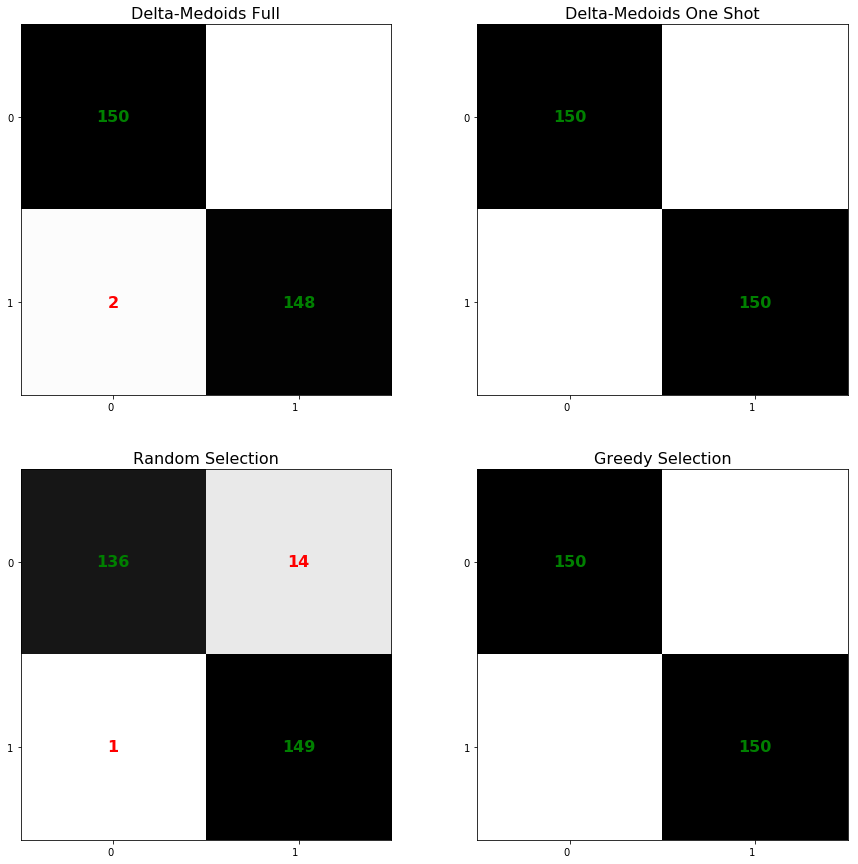

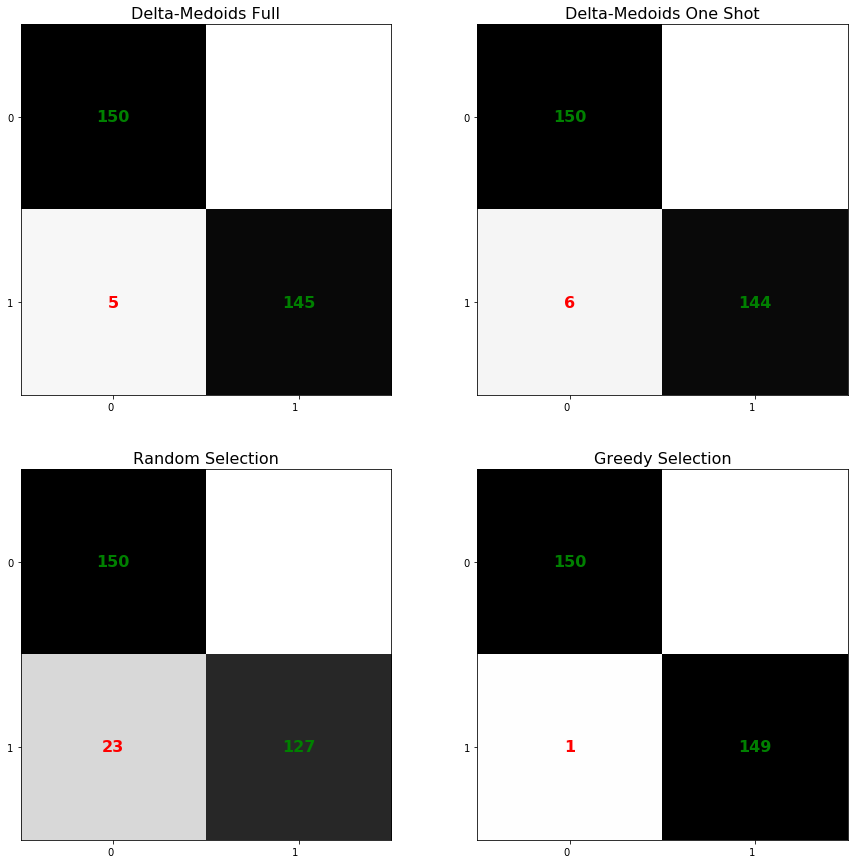

In [7]:
for i in range(0,5):
    matrices = butils.get_method_results(full_test_df, dataframes, distance.euclidean, None)

    matrix_full = matrices[0]
    matrix_one_shot = matrices[1]
    matrix_random_selection = matrices[2]
    matrix_greedy_select = matrices[3]

    precision_results = {"full_medoids" : butils.get_hit_miss_rate(matrix_full),
                         "one_shot_medoids" : butils.get_hit_miss_rate(matrix_one_shot),
                         "random_select" : butils.get_hit_miss_rate(matrix_random_selection),
                         "greedy_select" : butils.get_hit_miss_rate(matrix_greedy_select)}

    print("Rates for each method:")
    evaluation_sum = 0
    minimal_rate = ""
    for key in precision_results:
        print(key + ": " + str(precision_results[key]))
        if precision_results[key] < minimal_rate:
            minimal_rate = key
        
    print("Method that got the best result is " + minimal_rate)
    evaluation_sum = evaluation_sum + precision_results[minimal_rate]
    
    print("Creating plots.")
    benchmark_result_plots([matrix_full, matrix_one_shot, matrix_random_selection, matrix_greedy_select],
                       ['Delta-Medoids Full', 'Delta-Medoids One Shot', 'Random Selection', 'Greedy Selection'],
                       [names, names, names, names], i)
    
    for key in dataframes:
        dataframes[key].rotate()
    print("\n\nDataset Rotated!\n")

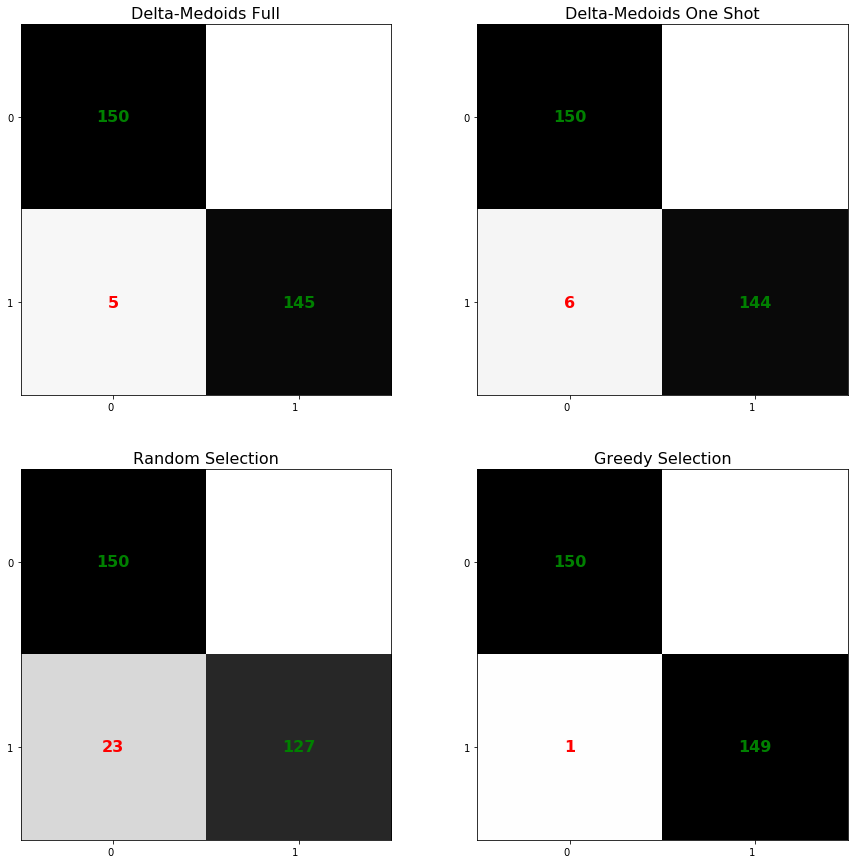

In [8]:
benchmark_result_plots([matrix_full, matrix_one_shot, matrix_random_selection, matrix_greedy_select],
                       ['Delta-Medoids Full', 'Delta-Medoids One Shot', 'Random Selection', 'Greedy Selection'],
                       [names, names, names, names], 100)

In [9]:
matrix_full

array([[150,   0],
       [  5, 145]])